In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load and process data

In [20]:
# Process data from Ewii
df_ewii = pd.read_csv("data/el-forbrugsrapport.csv", sep=";", skiprows=1, encoding="ISO-8859-1")
print(df_ewii.head(1).transpose())

# Prepare data: Fix danish chars, weird decimal chars etc.
# For some reason dates are not in ISO 8601... sigh
df_ewii.rename(columns={"Værdi(KWh)": "kWh_Ewii"}, inplace=True)
df_ewii["Datetime"] = pd.to_datetime(df_ewii["Dato"], infer_datetime_format=False, format='%d-%m-%Y %H:%M:%S')
df_ewii["kWh_Ewii"] = df_ewii["kWh_Ewii"].str.replace(",", ".")
df_ewii["kWh_Ewii"] = pd.to_numeric(df_ewii["kWh_Ewii"])
df_ewii.sort_values(by=['Datetime'])

# Set index
df_ewii.set_index("Datetime", inplace=True)
df_ewii.drop(columns=["Dato"], inplace=True)
df_ewii


                              0
Dato        01-03-2022 00:00:00
Værdi(KWh)             4,350000


,kWh_Ewii
Datetime,
2022-03-01 00:00:00,4.35
2022-03-01 01:00:00,4.78
2022-03-01 02:00:00,4.01
2022-03-01 03:00:00,3.71
2022-03-01 04:00:00,5.02
...,...
2023-01-21 19:00:00,2.01
2023-01-21 20:00:00,1.68
2023-01-21 21:00:00,2.42


In [21]:
# Process data from https://eloverblik.dk/customer/overview/
df_el = pd.read_csv("data/Meterdata_without_maalepunktsid.csv", sep=";",)
print(df_el.head(1).transpose())

# Prepare data: Fix danish chars, weird decimal chars etc.
# For some reason dates are not in ISO 8601... sigh
df_el.rename(columns={"Mængde": "kWh_eloverblik"}, inplace=True)
df_el["Datetime"] = pd.to_datetime(df_el["Fra_dato"], infer_datetime_format=False, format='%d-%m-%Y %H:%M:%S')
df_el["kWh_eloverblik"] = df_el["kWh_eloverblik"].str.replace(",", ".")
df_el["kWh_eloverblik"] = pd.to_numeric(df_el["kWh_eloverblik"])
df_el.sort_values(by=['Datetime'])

# Set index
df_el.set_index("Datetime", inplace=True)
# df_el.drop(columns=["Til_dato", "Fra_dato", "Måleenhed", "Kvalitet", "Type"], inplace=True)
df_el.drop(columns=["Til_dato", "Fra_dato", "Måleenhed", "Type"], inplace=True)
df_el

                             0
Fra_dato   01-03-2022 00:00:00
Til_dato   01-03-2022 01:00:00
Mængde                    4,35
Måleenhed                  KWH
Kvalitet                  Målt
Type                 Tidsserie


,kWh_eloverblik,Kvalitet
Datetime,,
2022-03-01 00:00:00,4.35,Målt
2022-03-01 01:00:00,4.78,Målt
2022-03-01 02:00:00,4.01,Målt
2022-03-01 03:00:00,3.71,Målt
2022-03-01 04:00:00,5.02,Målt
...,...,...
2023-01-22 19:00:00,2.68,Målt
2023-01-22 20:00:00,2.37,Målt
2023-01-22 21:00:00,2.71,Målt


# Merge the data

In [22]:
df = df_ewii.join(df_el, how="left")
df["kWh_diff"] = df["kWh_Ewii"] - df["kWh_eloverblik"]
df

,kWh_Ewii,kWh_eloverblik,Kvalitet,kWh_diff
Datetime,,,,
2022-03-01 00:00:00,4.35,4.35,Målt,0.0
2022-03-01 01:00:00,4.78,4.78,Målt,0.0
2022-03-01 02:00:00,4.01,4.01,Målt,0.0
2022-03-01 03:00:00,3.71,3.71,Målt,0.0
2022-03-01 04:00:00,5.02,5.02,Målt,0.0
...,...,...,...,...
2023-01-21 19:00:00,2.01,2.01,Målt,0.0
2023-01-21 20:00:00,1.68,1.68,Målt,0.0
2023-01-21 21:00:00,2.42,2.42,Målt,0.0


# Investigate the data

In [23]:
df.describe()

,kWh_Ewii,kWh_eloverblik,kWh_diff
count,7847.000000,7847.000000,7847.000000
mean,1.691596,1.682693,0.008903
std,1.659683,1.632488,0.199517
min,0.150000,0.150000,0.000000
25%,0.650000,0.650000,0.000000
50%,1.370000,1.370000,0.000000
75%,2.240000,2.230000,0.000000
max,25.280000,13.660000,12.640000


# Investigate the difference in the datasets

In [24]:
print(df.kWh_Ewii.sum())
print(df.kWh_eloverblik.sum())
print(df.kWh_diff.abs().sum())

13273.95
13204.089999999998
69.86


In [25]:
df.loc[df['kWh_Ewii'].idxmax(), :]

kWh_Ewii          25.28
kWh_eloverblik    12.64
Kvalitet           Målt
kWh_diff          12.64
Name: 2022-12-20 03:00:00, dtype: object

In [26]:
df.loc['2022-12-20':'2022-12-20']

,kWh_Ewii,kWh_eloverblik,Kvalitet,kWh_diff
Datetime,,,,
2022-12-20 00:00:00,5.02,2.51,Målt,2.51
2022-12-20 01:00:00,3.84,1.92,Målt,1.92
2022-12-20 02:00:00,3.82,1.91,Målt,1.91
2022-12-20 03:00:00,25.28,12.64,Målt,12.64
2022-12-20 04:00:00,11.48,5.74,Målt,5.74
2022-12-20 05:00:00,3.94,1.97,Målt,1.97
2022-12-20 06:00:00,4.96,2.48,Målt,2.48
2022-12-20 07:00:00,3.78,1.89,Målt,1.89
2022-12-20 08:00:00,3.22,1.61,Målt,1.61


In [27]:
print(len(df[df.kWh_diff.abs() > 0]))
df[df.kWh_diff.abs() > 0]


26


,kWh_Ewii,kWh_eloverblik,Kvalitet,kWh_diff
Datetime,,,,
2022-10-30 02:00:00,2.32,1.45,Målt,0.87
2022-10-30 02:00:00,2.32,0.87,Målt,1.45
2022-12-20 00:00:00,5.02,2.51,Målt,2.51
2022-12-20 01:00:00,3.84,1.92,Målt,1.92
2022-12-20 02:00:00,3.82,1.91,Målt,1.91
2022-12-20 03:00:00,25.28,12.64,Målt,12.64
2022-12-20 04:00:00,11.48,5.74,Målt,5.74
2022-12-20 05:00:00,3.94,1.97,Målt,1.97
2022-12-20 06:00:00,4.96,2.48,Målt,2.48


In [28]:
len)

SyntaxError: unmatched ')' (1159053887.py, line 1)

# Initial plot

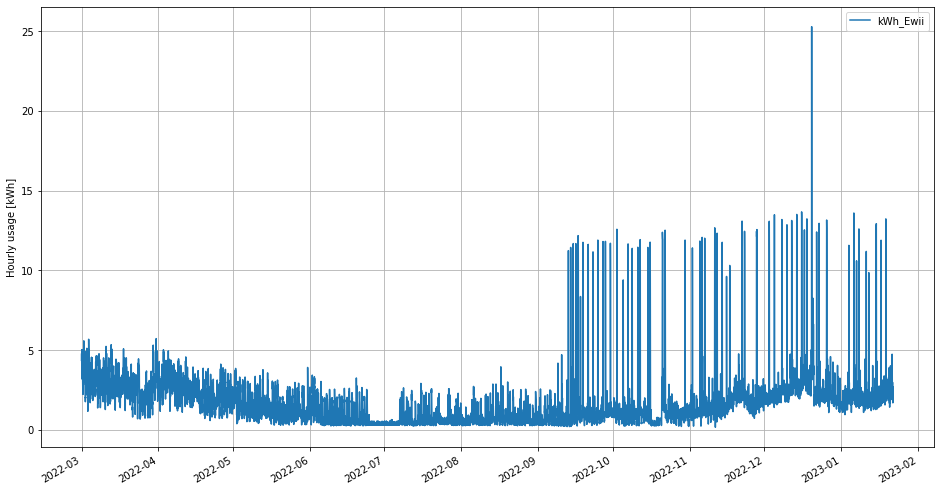

In [ ]:
ax = df.plot(
    y='kWh_Ewii',
    figsize=(16,9), 
    grid=True
    )
ax.set_ylabel('Hourly usage [kWh]');
ax.set_xlabel('');    

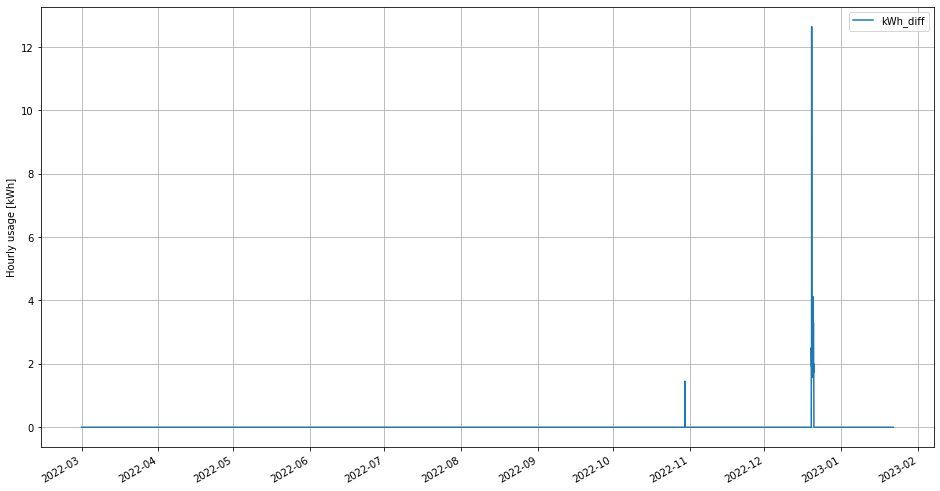

In [ ]:
ax = df.plot(
    y='kWh_diff',
    figsize=(16,9), 
    grid=True,
    )
ax.set_ylabel('Hourly usage [kWh]');
ax.set_xlabel('');    

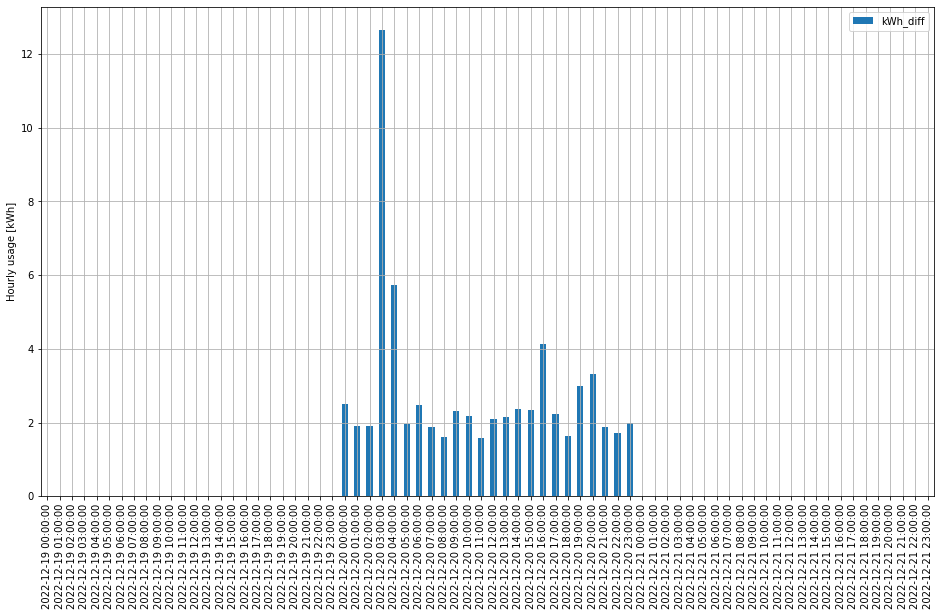

In [ ]:
df_plot_diff_zoom = df.loc['2022-12-19':'2022-12-21']
ax = df_plot_diff_zoom.plot(
    y='kWh_diff',
    figsize=(16,9), 
    grid=True,
    kind='bar'
    )
ax.set_ylabel('Hourly usage [kWh]');
ax.set_xlabel('');    

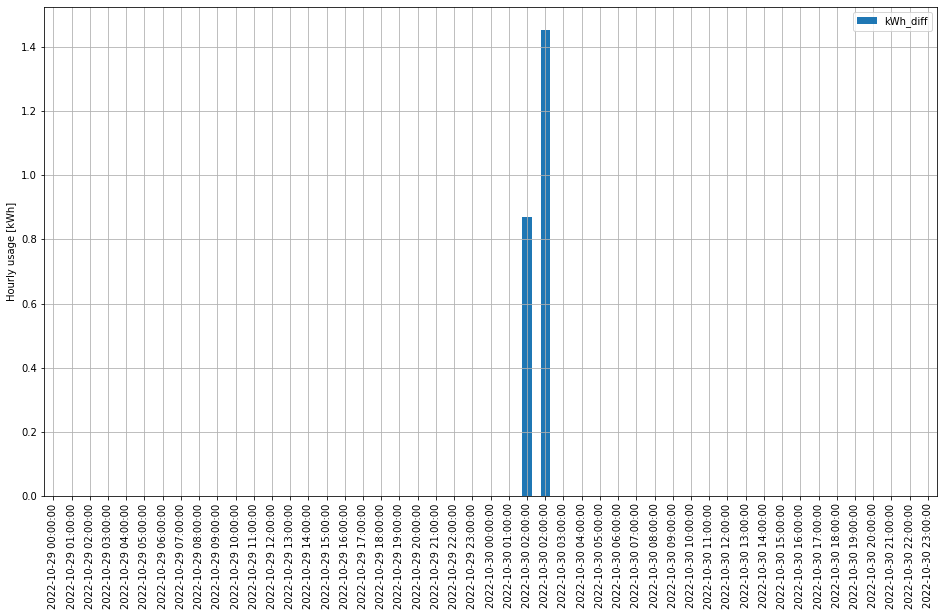

In [ ]:
df_plot_diff_zoom = df.loc['2022-10-29':'2022-10-30']
ax = df_plot_diff_zoom.plot(
    y='kWh_diff',
    figsize=(16,9), 
    grid=True,
    kind='bar'
    )
ax.set_ylabel('Hourly usage [kWh]');
ax.set_xlabel('');    

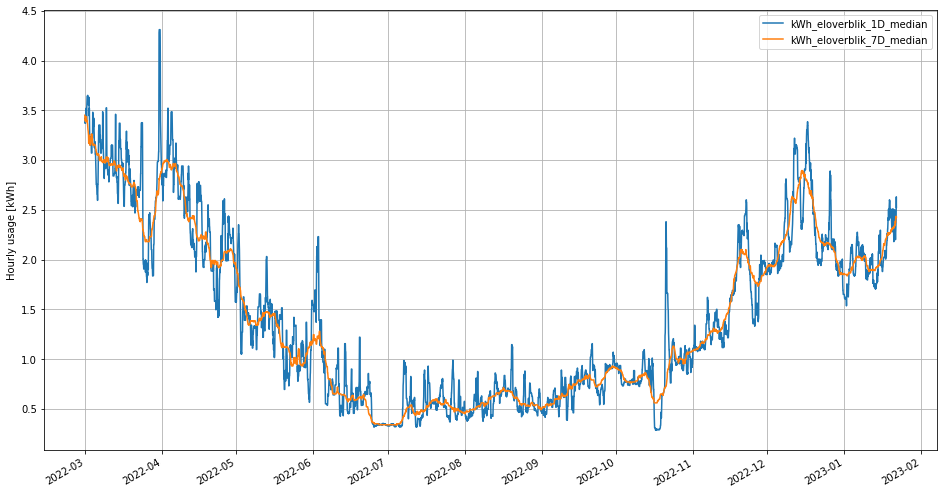

In [ ]:
# Plot averages
averages = [
    "1D",
    "7D",
    #"28D"
]

fig, ax = plt.subplots()
for avg in averages:
    _df_plot = df.copy()
    # _df_plot = df.query('WeekendFlag == False').copy()
    _df_plot = (
        _df_plot[["kWh_eloverblik"]].rolling(avg, min_periods=7, center=True).median().rename(columns={"kWh_eloverblik": f"kWh_eloverblik_{avg}_median"})
    )
    _df_plot.plot(ax=ax, figsize=(16,9), grid=True, label='kWh_{avg}_median')
ax.set_ylabel('Hourly usage [kWh]');
ax.set_xlabel('');